In [33]:
# %load ../Code/Fits.py
import Estimation as st
from Histogram import Histogram as hist
from PDF import PDF
from Utils import IsotopeDic, PartDic
from scipy.stats import poisson
import scipy.optimize as sop
import numpy as np
from scipy.special import gammaln
from copy import copy

def generalLogPoisson(x,mu):
    return -mu+x*np.log(mu)-gammaln(x+1)


class Fit():
    '''
    Class meant to perform the fit
    '''
    def __init__(self, E, spectrum, PDFs):
        '''
        E: x range (np array)
        spectrum: experimental points
        PDF: list of spectra PDFs
        nevs: normalizations for the spectra (they are the
            initial values for the fit)
        '''
        self.E = E[:]
        self.spectrum = spectrum.hist[:]
        for i in PDFs:
            print(i.Int)
        self.PDFs = copy(PDFs)#[pdf.Scale(1./pdf.Int) for pdf in PDFs]
        for i in PDFs:
            print(i.Int)

    def LogLikelihood(self, nevs):
        '''
        function meant to compute the LogLikelihood
        '''
        print(self.PDFs,nevs)
        ypdf = np.array([sum([n*pdfi.pdf(Ei) for pdfi,n in zip(self.PDFs,nevs)]) for Ei in self.E])
        ydat = self.spectrum
        print(type(ydat))
        print(type(ypdf))
        lm = (np.array(generalLogPoisson(ydat,ypdf))).sum()
        plt.plot(self.E,ypdf)
        plt.plot(self.E,ydat,'+')

        return -lm

    def FitLLM(self,nevs, **kwargs):
        nevs = np.array(nevs)
        fit = self.LogLikelihood
        res = sop.minimize(fit,nevs,**kwargs)
        ypdf = np.array([sum([n*pdfi.pdf(Ei) for pdfi,n in zip(self.PDFs,res.x)]) for Ei in self.E])
        ydat = self.spectrum
        chi2 = -1
        if (res.success):
            chi2 = np.sum((ypdf-ydat)**2)/(1.*(len(ypdf)-len(nevs)))
        res.chi2 = chi2
        return res


In [2]:
auxlist = np.random.normal(5,1.5,10000000)
a = hist(auxlist,100,0,15)
b = hist(auxlist+3,100,0,15)

In [3]:
ap = PDF(a,interpolation='linear')
bp = PDF(b,interpolation='linear')

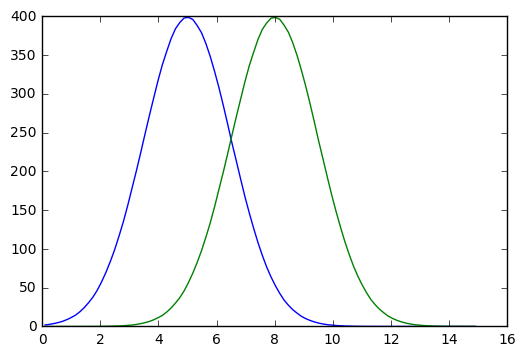

In [19]:
import matplotlib.pylab as plt
%matplotlib inline
x = np.linspace(0.1,14.9,100)
ya = 10000*ap.pdf(x)
yb = 10000*bp.pdf(x)
plt.plot(x,ya)
plt.plot(x,yb)

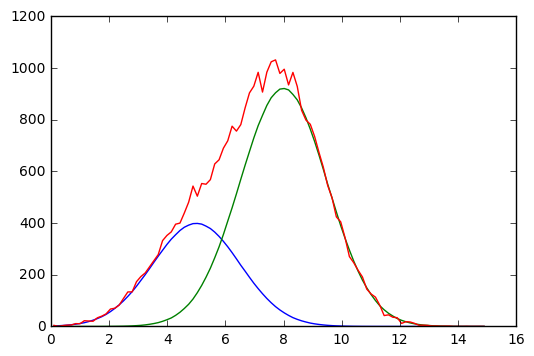

In [20]:
ydata = np.abs(np.random.normal(ya+2.31*yb,np.sqrt(ya+2.31*yb)))
hdata = hist([],100,0,15)
hdata.hist = ydata
hdata.bins = x
plt.plot(x,ya)
plt.plot(x,2.31*yb)
plt.plot(x,ydata)

In [35]:
fit = Fit(x,hdata,[ap,bp])

0.15
0.15
0.15
0.15


[<PDF.PDF object at 0x7fbd40539da0>, <PDF.PDF object at 0x7fbd40539c88>] [100.0, 100.0]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


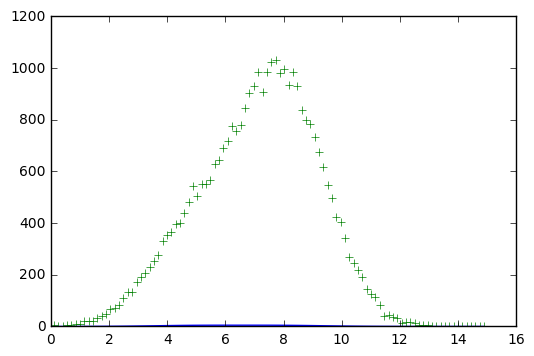

In [26]:
w = fit.LogLikelihood([100.,100.])
#plt.plot(x,e)
#plt.plot(x,r)


[<PDF.PDF object at 0x7fbd40539da0>, <PDF.PDF object at 0x7fbd40539c88>] [  1000.  30000.]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[<PDF.PDF object at 0x7fbd40539da0>, <PDF.PDF object at 0x7fbd40539c88>] [  1000.00000001  30000.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[<PDF.PDF object at 0x7fbd40539da0>, <PDF.PDF object at 0x7fbd40539c88>] [  1000.          30000.00000001]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[<PDF.PDF object at 0x7fbd40539da0>, <PDF.PDF object at 0x7fbd40539c88>] [  1000.  30000.]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[<PDF.PDF object at 0x7fbd40539da0>, <PDF.PDF object at 0x7fbd40539c88>] [  1001.00999154  29999.99586621]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[<PDF.PDF object at 0x7fbd40539da0>, <PDF.PDF object at 0x7fbd40539c88>] [  1001.00999154  29999.99586621]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[<PDF.PDF object at 0x7fbd40539da0>, <PDF.PDF object at 0x7fbd40539c88>] [  1001.00999156  29999.99586

     chi2: 851.05764216686543
      fun: 405.70809268883784
 hess_inv: array([[  6819.13431771,  -4193.81997582],
       [ -4193.81997582,  32794.06351321]])
      jac: array([ 0.07788086,  0.00371933])
  message: 'Optimization terminated successfully.'
     nfev: 112
      nit: 21
     njev: 28
   status: 0
  success: True
        x: array([ 11401.37396583,  22827.56296218])

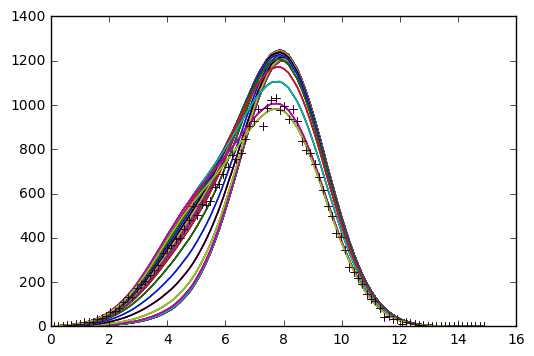

In [36]:
fit.FitLLM([1000.,30000.], tol=0.1)

In [9]:
a = hist([],100,0,10)